ORES HDFS Data Inspection
===

See https://phabricator.wikimedia.org/T277609


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import json
from datetime import datetime
import dateutil
import pytz
from tqdm import tqdm

In [4]:
ores_preds_2019_filepath = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/raw/editquality/hdfs/ores_scores_damaging-goodfaith_enwiki_2019_01-12.json"
TRUSTED_GROUPS = ['sysops','oversight','bot','rollbacker','checkuser','abusefilter','bureaucrat']

In [5]:
iso_string = "2019-12-31T23:59:59Z"
dt = dateutil.parser.isoparse(iso_string)
dt, dt.timestamp(), int(datetime.strptime(iso_string, "%Y-%m-%dT%H:%M:%SZ").timestamp())

(datetime.datetime(2019, 12, 31, 23, 59, 59, tzinfo=tzutc()),
 1577836799.0,
 1577858399)

In [19]:
missing_registration_date_count = 0
with open(ores_preds_2019_filepath, 'r') as infile:
    lines = []
    for line in tqdm(infile, total=54683129):
        op = json.loads(line)
        rev_id = op['rev_id']
        pred_timestamp = dateutil.parser.isoparse(op['pred_dt']).timestamp()

        user = op['performer']
        user_text = user['user_text']
        user_is_bot = user['user_is_bot']
        user_id = user['user_id'] if 'user_id' in user else None
        user_groups = set(user['user_groups'])
        if user_id:
            user_is_trusted = np.any([group in TRUSTED_GROUPS for group in user_groups])
            user_edit_count = user['user_edit_count']
            if 'user_registration_dt' not in user:
                missing_registration_date_count += 1
            #else:
                #user_registration_timestamp = dateutil.parser.isoparse(user['user_registration_dt']).timestamp()
        else:
            user_is_trusted = False
            user_edit_count = 0


        dinfo = op['damaging_info']
        model_version = dinfo['model_version']
        damaging_pred = dinfo['probability']['true']

        gfinfo = op['goodfaith_info']
        #assert gfinfo['model_version'] == model_version
        goodfaith_pred = dinfo['probability']['true']

        lines.append({
            'rev_id': rev_id,
            'pred_timestamp': pred_timestamp,
            'user_text': user_text,
            'user_is_bot': user_is_bot,
            'user_is_trusted': user_is_trusted,
            'user_edit_count': user_edit_count,
            'model_version': model_version,
            'damaging_pred': damaging_pred,
            'goodfaith_pred': goodfaith_pred,
        })

100%|██████████| 54683129/54683129 [1:04:30<00:00, 14128.64it/s]


In [20]:
s = datetime.now()
df = pd.DataFrame(lines)
len(df), datetime.now() - s

(54683129, datetime.timedelta(seconds=165, microseconds=48004))

In [21]:
df.head()

,rev_id,pred_timestamp,user_text,user_is_bot,user_is_trusted,user_edit_count,model_version,damaging_pred,goodfaith_pred
0,876227280,1.546301e+09,InternetArchiveBot,True,True,3109800,0.4.0,0.005061,0.005061
1,876227282,1.546301e+09,DynamoDegsy,False,False,158278,0.4.0,0.011485,0.011485
2,876227283,1.546301e+09,TerribleTy2727,False,False,46,0.4.0,0.221970,0.221970
3,876227281,1.546301e+09,175.36.4.199,False,False,0,0.4.0,0.265990,0.265990
4,876227286,1.546301e+09,InceptionBot,True,True,1156474,0.4.0,0.005774,0.005774


In [22]:
df.model_version.value_counts()

0.5.0    53626234
0.4.0     1056895
Name: model_version, dtype: int64

In [24]:
oidb_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/oidb"
s = datetime.now()
df.to_feather(os.path.join(oidb_dir, 'ores_2019.feather'))
print(f"Finished saving to feather in {datetime.now() - s}.")

Finished saving to feather in 0:00:16.917394.


In [28]:
# free up some memory
del lines

In [6]:
# read in the ores predictions
oidb_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/oidb"
s = datetime.now()
ores_df = pd.read_feather(os.path.join(oidb_dir, 'ores_2019.feather'))
print(f"Loaded {len(ores_df)} rows from feather in {datetime.now() - s}.")
ores_df.head()

Loaded 54683129 rows from feather in 0:00:16.972204.


,rev_id,pred_timestamp,user_text,user_is_bot,user_is_trusted,user_edit_count,model_version,damaging_pred,goodfaith_pred
0,876227280,1.546301e+09,InternetArchiveBot,True,True,3109800,0.4.0,0.005061,0.005061
1,876227282,1.546301e+09,DynamoDegsy,False,False,158278,0.4.0,0.011485,0.011485
2,876227283,1.546301e+09,TerribleTy2727,False,False,46,0.4.0,0.221970,0.221970
3,876227281,1.546301e+09,175.36.4.199,False,False,0,0.4.0,0.265990,0.265990
4,876227286,1.546301e+09,InceptionBot,True,True,1156474,0.4.0,0.005774,0.005774


In [7]:
ores_df.sample(n=10)

,rev_id,pred_timestamp,user_text,user_is_bot,user_is_trusted,user_edit_count,model_version,damaging_pred,goodfaith_pred
35246567,913054647,1.567094e+09,2.247.249.186,False,False,0,0.5.0,0.239383,0.239383
28216418,905034672,1.562411e+09,Beevest,False,False,51,0.5.0,0.440418,0.440418
1594552,877850814,1.547195e+09,24.23.186.89,False,False,0,0.5.0,0.158283,0.158283
38944150,916810976,1.569007e+09,Zigzig20s,False,False,178104,0.5.0,0.004293,0.004293
3500069,879786362,1.548242e+09,Diannaa,False,False,245323,0.5.0,0.004084,0.004084
53043954,931773050,1.576898e+09,Apollinaire93,False,False,266,0.5.0,0.056603,0.056603
33291569,911057691,1.565944e+09,RichieBlondet,False,False,35,0.5.0,0.033426,0.033426
53144964,931875585,1.576964e+09,SchreiberBike,False,False,242221,0.5.0,0.005067,0.005067
42671571,921209481,1.571066e+09,Sagar The Editor,False,False,31,0.5.0,0.051141,0.051141
11189652,887635373,1.552514e+09,Mramoeba,False,False,3969,0.5.0,0.007930,0.007930


In [15]:
s = datetime.now()
ores_df = ores_df.sort_values(by='pred_timestamp', ascending=True)
print(f"Finished sort in {datetime.now() - s}.")

Finished sort in 0:00:09.172891.


In [16]:
# 1277 duplicate rev_ids
s = datetime.now()
rev_counts = ores_df.rev_id.value_counts()
print(f"Identified {len(rev_counts)} unique rev_ids of which {np.sum(rev_counts > 1)} are duplicated at least once. Done in {datetime.now() - s}.")
rev_counts[rev_counts > 1].head(20)

Identified 54681789 unique rev_ids of which 1277 are duplicated at least once. Done in 0:00:18.882783.


899529828    5
920236003    4
920235961    4
920235996    4
895233079    3
920236002    3
897298148    3
924403009    3
920236006    3
920235990    3
931428681    3
899514155    3
914334321    3
916183612    3
914334401    3
924403016    3
896140848    3
920235992    3
900656693    3
919177360    3
Name: rev_id, dtype: int64

In [8]:
rev_id_pred_timestamp_dict = {
    rev_id: pred_timestamp
    for rev_id, pred_timestamp in tqdm(zip(ores_df.rev_id, ores_df.pred_timestamp), total=len(ores_df))
}
len(rev_id_pred_timestamp_dict)

100%|██████████| 54683129/54683129 [00:29<00:00, 1877645.94it/s]


54681789

In [10]:
start_date = datetime.fromisoformat('2019-01-01').replace(tzinfo=pytz.UTC)  # start of 2019
start_timestamp = int(start_date.timestamp())
midpoint_date = datetime.fromisoformat('2020-01-01').replace(tzinfo=pytz.UTC)
midpoint_timestamp = int(midpoint_date.timestamp())
end_date = datetime.fromisoformat('2021-01-01').replace(tzinfo=pytz.UTC)
end_timestamp = int(end_date.timestamp())
with open(os.path.join(oidb_dir, 'revs.tsv'), 'r') as infile:
    processed_count = 0
    missing_rev_count = 0
    missing_in_2019_count = 0
    missing_rev_ids = set()
    pred_delay_list = []
    for line in tqdm(infile, total=117569278, desc='Reading revision data'):
        processed_count += 1
        tokens = line.strip().split('\t')
        assert len(tokens) == 20
        rev_timestamp, page_id, rev_id, prev_rev_id, is_minor, user_text, user_id, seconds_to_prev, curr_bytes, delta_bytes, has_edit_summary, is_reverted, is_revert, is_reverted_to_by_other, is_self_reverted, is_self_revert, revert_target_id, revert_set_size, revert_id, seconds_to_revert = tokens
        rev_id = int(rev_id)
        rev_timestamp = int(rev_timestamp)
        if rev_id not in rev_id_pred_timestamp_dict:
            missing_rev_count += 1
            if rev_timestamp >= start_timestamp and rev_timestamp <= midpoint_timestamp:
                missing_in_2019_count += 1
                missing_rev_ids.add(rev_id)
        else:
            pred_timestamp = rev_id_pred_timestamp_dict[rev_id]
            pred_delay_list.append(pred_timestamp - int(rev_timestamp))
missing_rev_count, processed_count

Reading revision data: 117579242it [07:15, 270151.42it/s]                               


(64785418, 117579242)

In [11]:
missing_rev_count / processed_count

0.5509936694437952

In [14]:
# 2% of the missing revisions are from 2019.
missing_in_2019_count, missing_in_2019_count / processed_count

(2336608, 0.019872623434670552)

In [17]:
# save the missing revisions
oidb_dir = "/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions/oidb"
missing_rev_id_list = sorted(list(missing_rev_ids))
with open(os.path.join(oidb_dir, 'rev_ids_missing_scores.txt'), 'w') as outfile:
    for rev_id in missing_rev_id_list:
        outfile.write(str(rev_id) + "\n")
print("Finished.")

Finished.


In [20]:
list(rev_id_pred_timestamp_dict)[-1]

933439940

In [25]:
pred_delay_list = np.array(pred_delay_list)
len(pred_delay_list)

52793834

In [33]:
pred_delay_list += 18000

In [34]:
np.min(pred_delay_list), \
np.quantile(pred_delay_list, 0.01), \
np.quantile(pred_delay_list, 0.5), \
np.quantile(pred_delay_list, 0.99),\
np.max(pred_delay_list)

(-3599.4960000514984,
 -3598.4749999046326,
 2.4809999465942383,
 80.54600992441713,
 486387.1930000782)

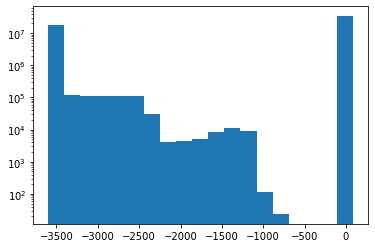

In [35]:
fig, ax = plt.subplots()

bins= np.linspace(np.quantile(pred_delay_list, 0.01), np.quantile(pred_delay_list, 0.99), num=20)
ax.hist(pred_delay_list, bins=bins, log=True)

plt.show()